### Whole-Brain Model

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/StuartLandauWBM/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate_delayed

#### Config

In [3]:
jax.config.update("jax_platform_name", "gpu")

#### Load anatomical data

In [4]:
## Load anatomical data
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

#### Simulation parameters


In [5]:
ntrials = 100
fsamp = 1 / 1e-4
time = np.arange(-2, 5, 1 / fsamp)
beta = 0.001
Npoints = len(time)

f = 40

flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.2)] = 1
Amplitudes = np.linspace(0, .1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)
a_vec = np.hstack(([-5], -5 + np.cumsum(np.diff(h)) * 5))

data = []
for n in tqdm(range(ntrials)):
    temp = simulate_delayed(
        flnMat,
        D,
        10,
        f,
        a_vec,
        fsamp,
        beta,
        Npoints,
        CS[n] * Iext,
        seeds[n],
        "cpu",
        15,
        "amp",
    )
    data += [temp]

data = np.stack(data)
data = data.squeeze().transpose(0, 2, 1)
# Output the shapes of data and datah for verification
data.shape

100%|██████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


(100, 29, 4667)

#### Convert to xarray

In [6]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

data = xr.DataArray(
    data,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, area_names, time[::15]),
)

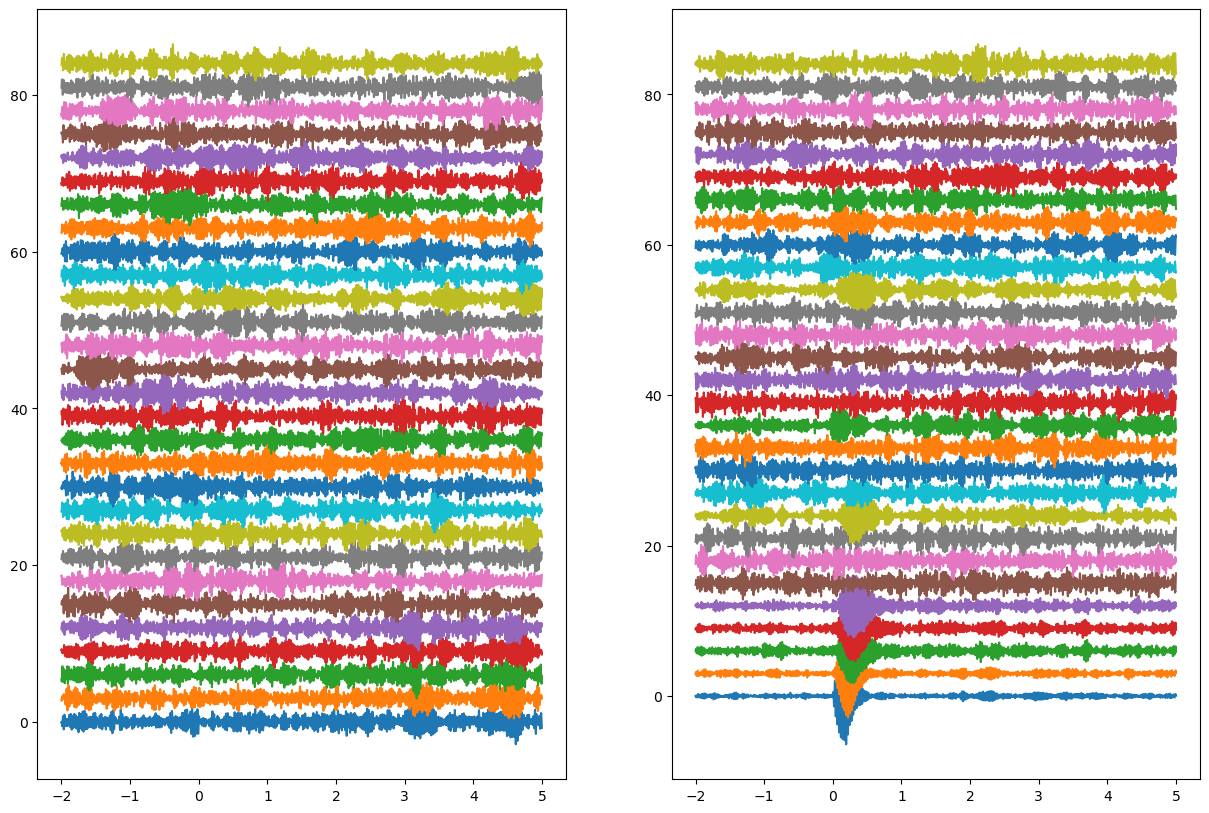

In [7]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

#### Decompose in time-frequency domain

In [8]:
data = data.sel(times=slice(-0.2, 3))


freqs = np.linspace(0.3, 80, 30)

S = tfr_array_morlet(
    data.values.real,
    fsamp / 15,
    freqs,
    freqs / 7,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": area_names},
)

In [9]:
steps = xr.DataArray((D[0] * fsamp / 15).astype(int), dims=("roi"), coords=(area_names,))

#### Decompose in time-frequency domain

100%|████████████████████████████████████████████████████████| 28/28 [01:39<00:00,  3.55s/it]


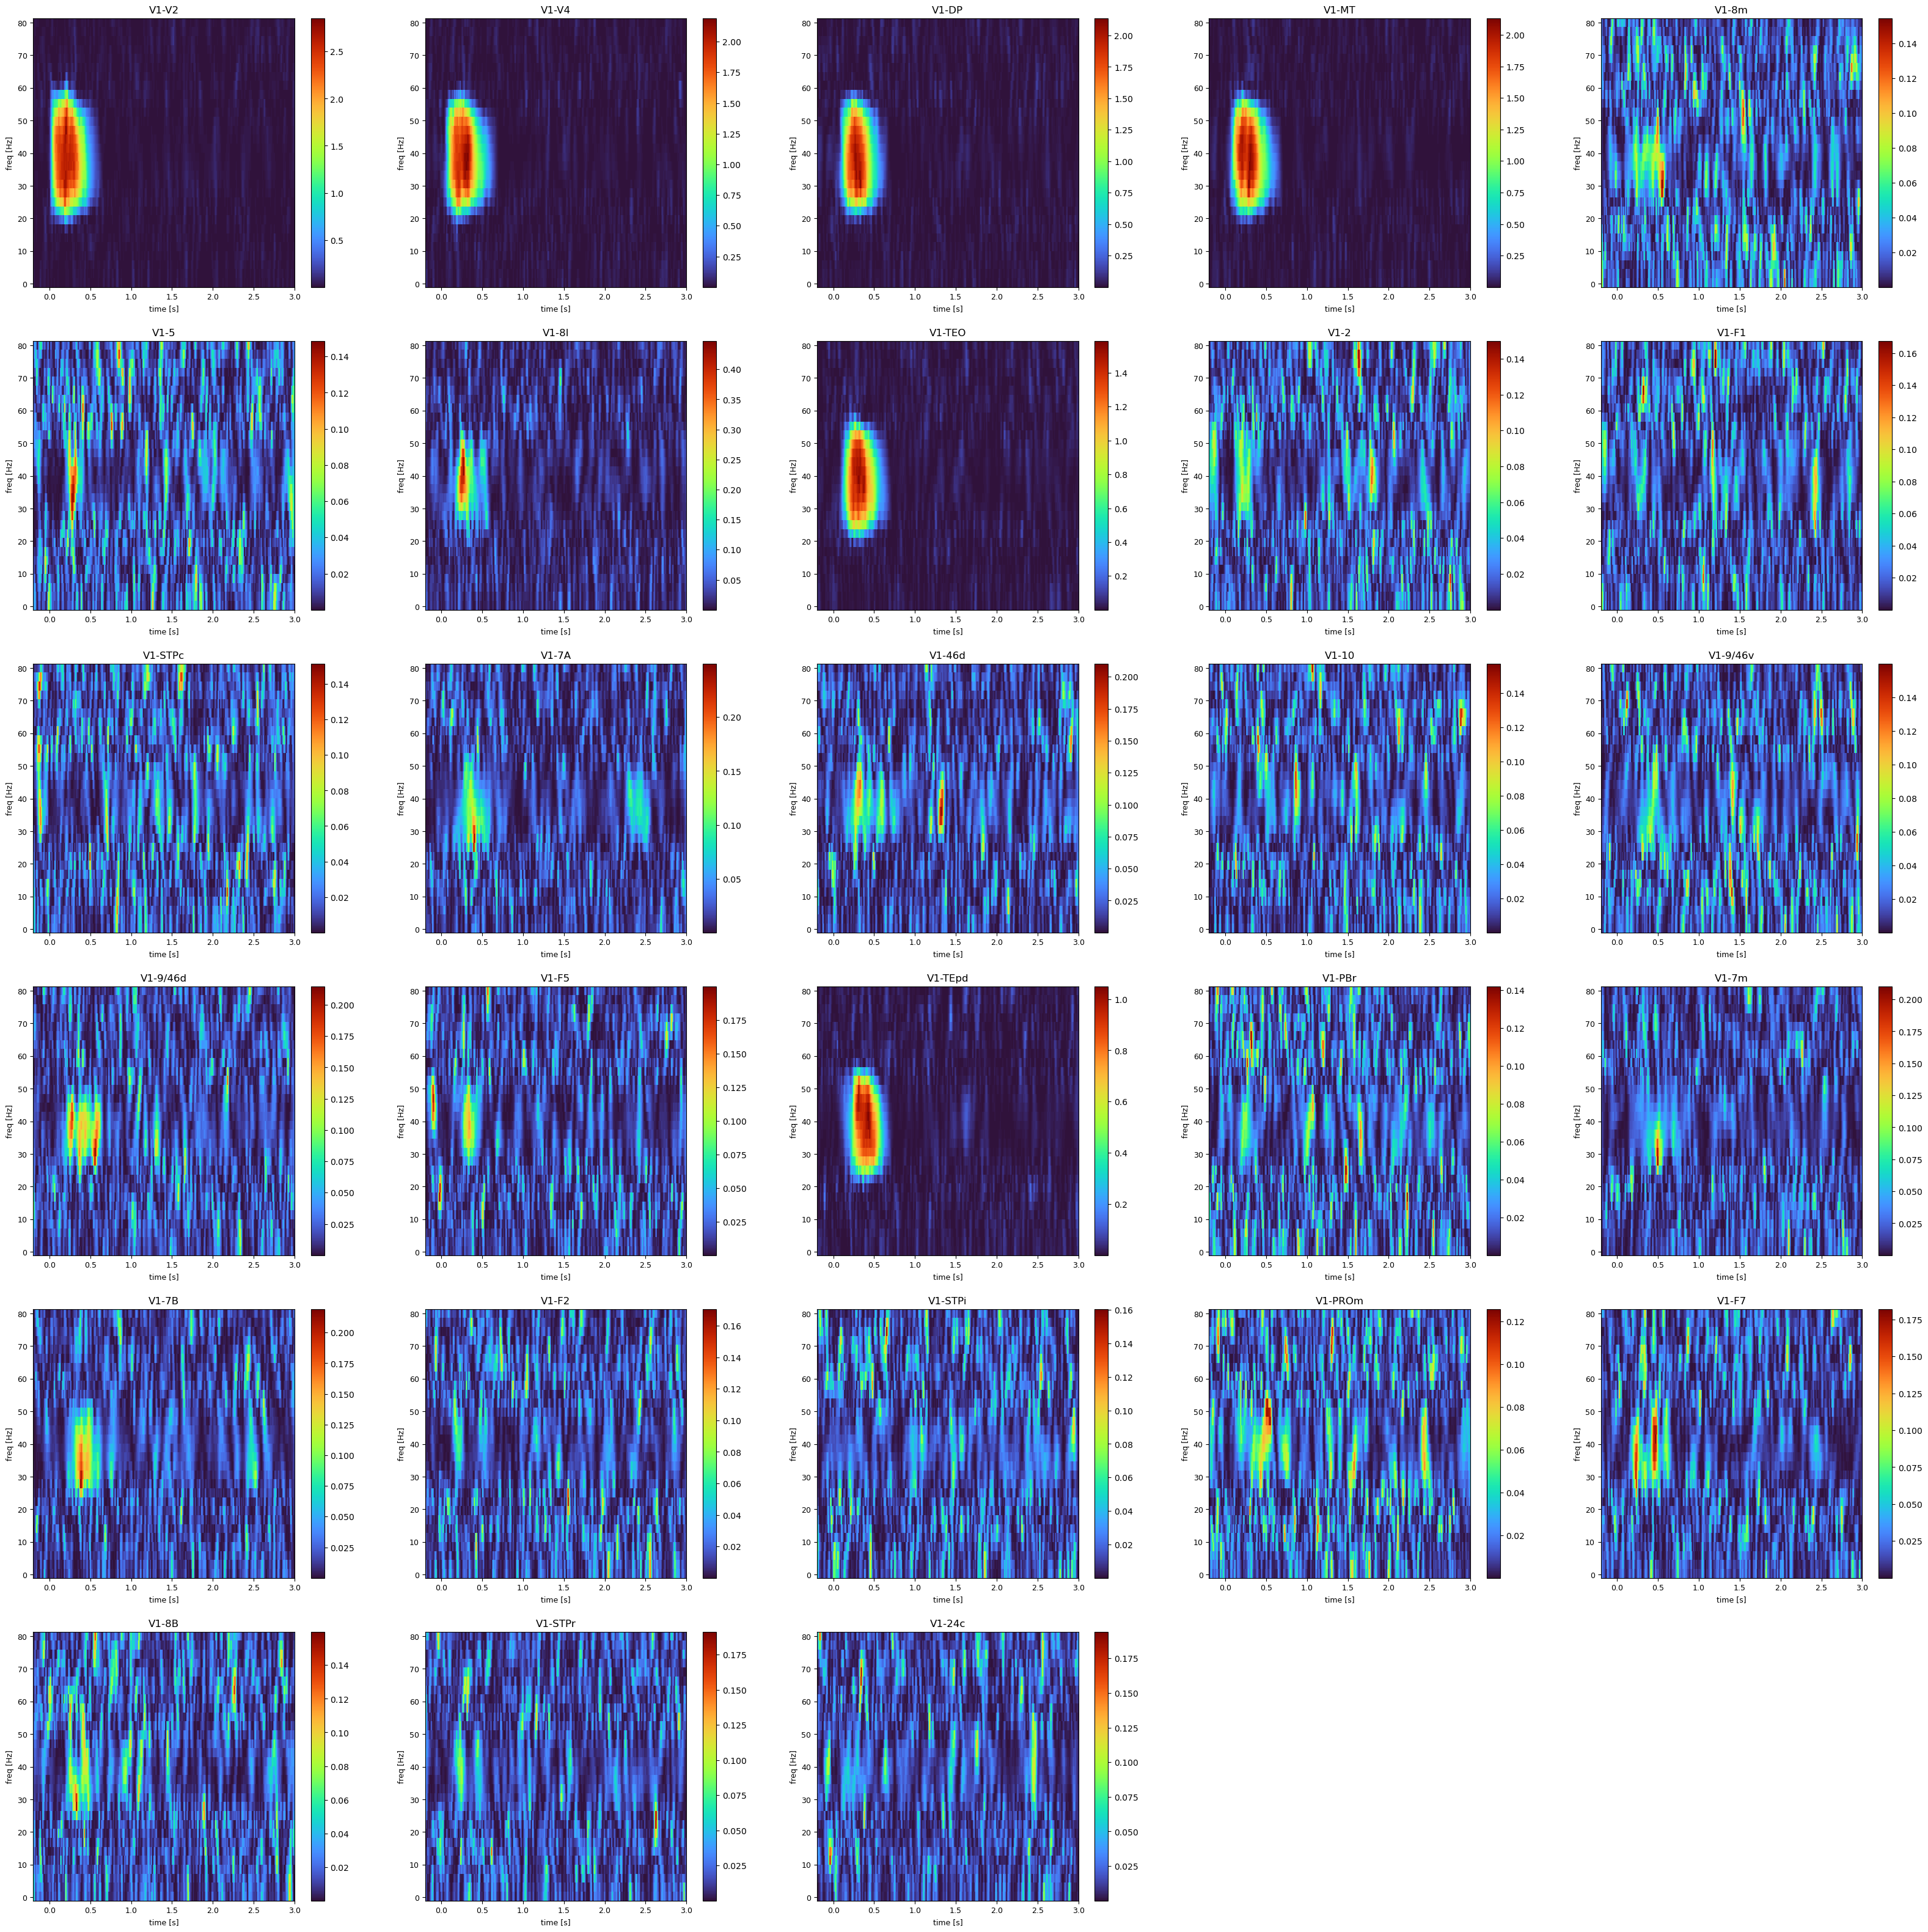

In [10]:
def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gcmi")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.stack([[[0] * 28], [range(1, 29)]], axis=1).squeeze().T

rois = S.roi.values
stim = data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]


plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)

In [11]:
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc


def _syn(R1, R2, stim):

    MI_13 = gcmi_nd_cc(R1, stim, traxis=0)
    MI_23 = gcmi_nd_cc(R2, stim, traxis=0)
    MI_123 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    Red = np.minimum(MI_13, MI_23)
    return MI_123 - MI_13 - MI_23 + Red


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)

In [12]:
stim = xr.DataArray(
    np.array(CS[:, 0]),
    dims=("trials", "times"),
    coords=(
        range(ntrials),
        time,
    ),
)
stim_ = stim.sel(times=slice(-0.2, 3)).values[..., ::15][..., :-1]

In [13]:
U_R1 = []
U_R2 = []
U_R3 = []

for roi in tqdm(data.roi.values[1:]):

    Z = data.sel(roi=["V1", roi])

    A1, A2 = np.abs(Z[:, 0]), np.abs(Z[:, 1])

    dphi = Z[:, 0] * np.conj(Z[:, 1]) / np.sqrt(A1 * A2)

    A1 = np.asarray(A1)
    A2 = np.asarray(A2)
    dphi = np.asarray(dphi)

    I_S_R1 = gcmi_nd_cc(A1, stim_, traxis=0)
    I_S_R2 = gcmi_nd_cc(A2, stim_, traxis=0)
    I_S_R3 = gcmi_nd_cc(dphi, stim_, traxis=0)
    I_S_R1_R2 = gccmi_nd_ccc(A1, A2, stim_, traxis=0)

    U_R1 += [I_S_R1 - np.minimum(I_S_R1, gccmi_nd_ccc(A2, dphi, stim_, traxis=0))]

    U_R2 += [I_S_R2 - np.minimum(I_S_R2, gccmi_nd_ccc(A1, dphi, stim_, traxis=0))]

    U_R3 += [I_S_R3 - np.minimum(I_S_R3, gccmi_nd_ccc(A1, A2, stim_, traxis=0))]

100%|████████████████████████████████████████████████████████| 28/28 [00:18<00:00,  1.48it/s]


In [14]:
Un = xr.DataArray(
    np.stack((U_R1, U_R2, U_R3)),
    dims=("metric", "roi", "time"),
    coords=(
        ["A1", "A2", "A3"],
        area_names[1:],
        data.times.values,
    ),
)

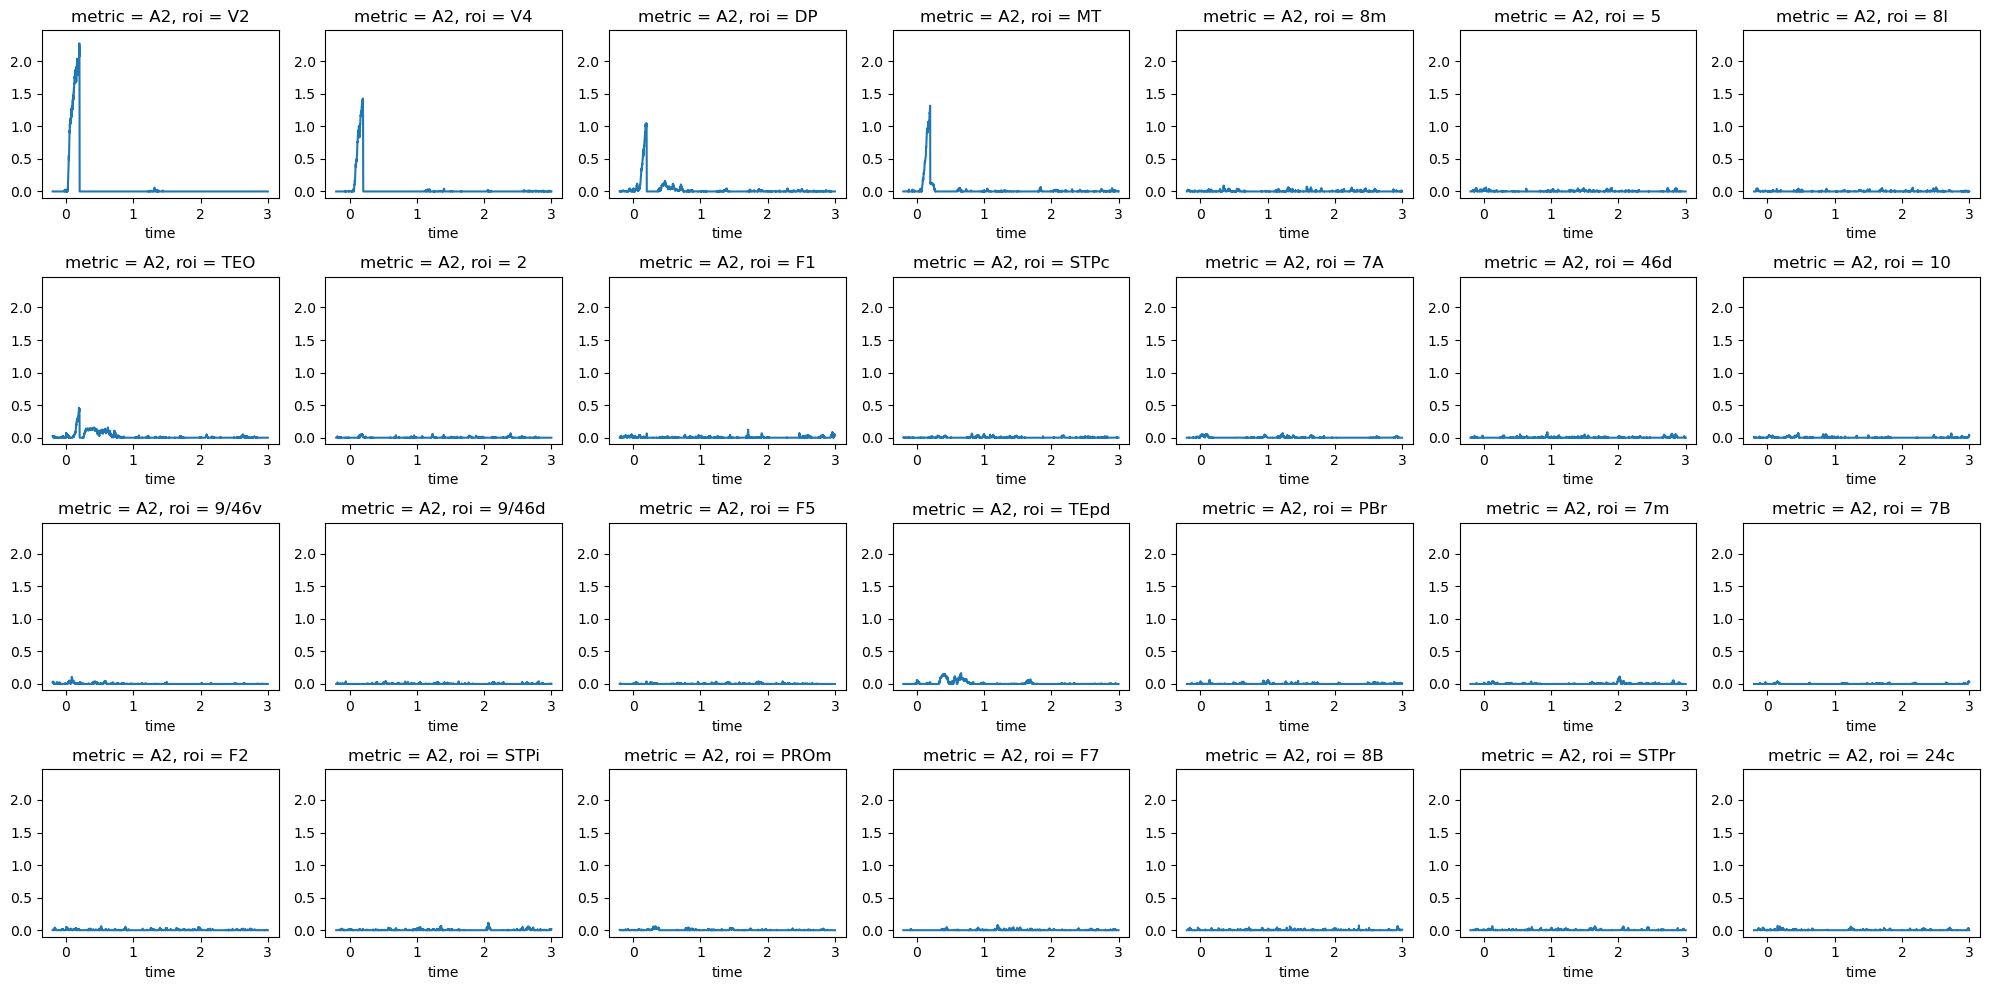

In [15]:
plt.figure(figsize=(20, 10))
for i in range(28):
    plt.subplot(4, 7, i + 1)
    Un.sel(metric="A2").isel(roi=i).plot()
    plt.ylim(-0.1, Un.sel(metric=["A2", "A3"]).max() + .2)
plt.tight_layout()

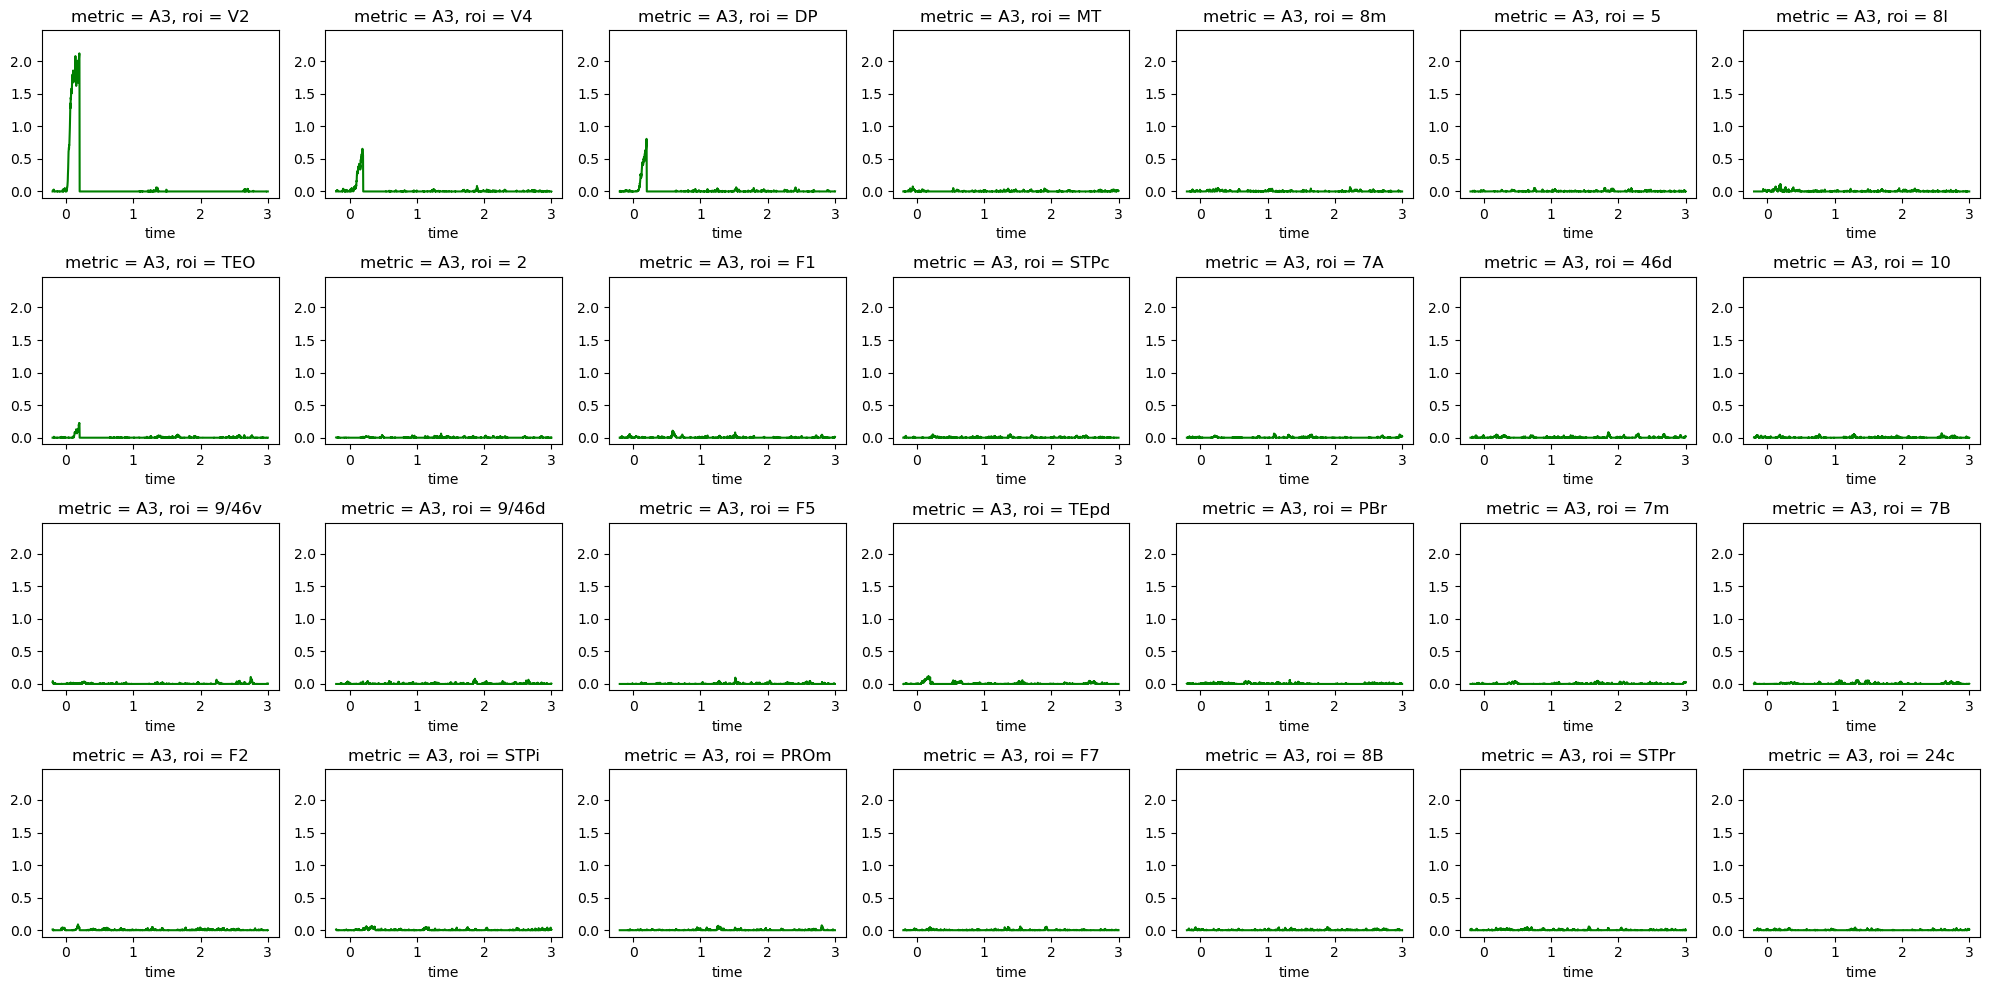

In [16]:
plt.figure(figsize=(20, 10))
for i in range(28):
    plt.subplot(4, 7, i + 1)
    Un.sel(metric="A3").isel(roi=i).plot(c="green")
    plt.ylim(-0.1, Un.sel(metric=["A2", "A3"]).max() + .2)
plt.tight_layout()